In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Conv1D, AveragePooling1D, UpSampling1D, Add
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

/home/user/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
n_inds = 10
training_folders = ['0066']#, '0105']
validation_folders = ['0126']

In [5]:
for i,name in enumerate(training_folders):
    tmp = pd.read_hdf('/mnt/ssd1/Documents/Vivek/dnn/vision_leadership/golden_shiners/10_fish/' + name + '/' + name + '.h5')
    tmp['vid_id'] = i
    if i != 0:
        df_train = np.concatenate((df_train,tmp), axis=0)
    else:
        df_train = tmp
        
for i,name in enumerate(validation_folders):
    tmp = pd.read_hdf('/mnt/ssd1/Documents/Vivek/dnn/vision_leadership/golden_shiners/10_fish/' + name + '/' + name + '.h5')
    tmp['vid_id'] = i
    if i != 0:
        df_validation = np.concatenate((df_validation,tmp), axis=0)
    else:
        df_validation = tmp

df_train = pd.DataFrame(df_train)
df_validation = pd.DataFrame(df_validation)

df_train.columns = ['frame', 'ang_area_left_eye', 'ang_area_right_eye', 'f_id', 'n_id', 'tau', 'cc', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye', 'vid_id']
df_validation.columns = ['frame', 'ang_area_left_eye', 'ang_area_right_eye', 'f_id', 'n_id', 'tau', 'cc', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye', 'vid_id']

In [6]:
one_hot_cc_train = to_categorical(df_train['cc'])
one_hot_tau_train = to_categorical(df_train['tau'])

one_hot_cc_validation = to_categorical(df_validation['cc'])
one_hot_tau_validation = to_categorical(df_validation['tau'])

one_hot_cc_train.shape, one_hot_tau_train.shape, one_hot_cc_validation.shape, one_hot_tau_validation.shape

((2176020, 2), (2176020, 126), (2170170, 11), (2170170, 11))

In [25]:
niters = 7
padding = 'causal'

def pool_conv(conv_in, nfilters):
    pool = AveragePooling1D(pool_size=2)(conv_in)
    conv = Conv1D(filters=nfilters, kernel_size=3, padding=padding, activation='selu', use_bias=False)(pool)
    return pool, conv

def upsample_add_deconv(upsamp_in, res, nfilters):
    upsample = UpSampling1D(size=2)(upsamp_in)
    add = Add()([res,upsample])
    deconv = Conv1D(filters=nfilters, kernel_size=3, padding=padding, activation='selu', use_bias=False)(add)
    return upsample, add, deconv

In [26]:
input_layer = Input(batch_shape=(None, None, 6))

convs=[None]*niters
pools=[None]*(niters-1)
start_nfilters_exponent = 3        # 2**3 = 8 i.e. starting number of filters is 8

convs[0] = Conv1D(filters=2**start_nfilters_exponent, kernel_size=3, padding=padding, activation='selu', use_bias=False)(input_layer)
for i in range(1,niters):
    pools[i-1], convs[i] = pool_conv(convs[i-1], 2**(start_nfilters_exponent+i))

ress=[None]*(niters-1)
for i in range(niters-1):
    ress[i] = Conv1D(filters=2**(start_nfilters_exponent+i+1), kernel_size=1, padding=padding, activation='selu', use_bias=False)(convs[i])
    
upsamples=[None]*(niters-1)
adds=[None]*(niters-1)
deconvs=[None]*(niters-1)

upsamples[-1], adds[-1], deconvs[-1] = upsample_add_deconv(convs[-1], ress[-1], 2**(start_nfilters_exponent+len(ress)-1))
for i in range(niters-2,0,-1):
    upsamples[i-1], adds[i-1], deconvs[i-1] = upsample_add_deconv(deconvs[i], ress[i-1], 2**(start_nfilters_exponent+i-1))

output_layer = Conv1D(filters=22, kernel_size=3, padding=padding, activation='linear')(deconvs[0])

model = Model(input_layer, output_layer)
model.compile(Adam(lr=0.001, amsgrad=True), loss='mse')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [29]:
half_batch = 4096
def generate_training_batch():
    vid_id = np.random.randint(0,len(training_folders))
    f_id = np.random.randint(0,n_inds)
    while (True):
        n_id = np.random.randint(0,n_inds)
        if n_id != f_id:
            break
    #tmp = df_train[(df_train['vid_id'] == vid_id) & (df_train['f_id'] == f_id) & (df_train['n_id'] == n_id)]
    tmp_cc = one_hot_cc_train[(df_train['vid_id'] == vid_id) & (df_train['f_id'] == f_id) & (df_train['n_id'] == n_id)]
    tmp_tau = one_hot_tau_train[(df_train['vid_id'] == vid_id) & (df_train['f_id'] == f_id) & (df_train['n_id'] == n_id)]
    
    idx = np.random.randint(half_batch,tmp.shape[0]-half_batch)
    x = tmp[idx-half_batch:idx+half_batch][['ang_area_left_eye', 'ang_area_right_eye', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye']].values[None,...]
    y = np.concatenate((tmp_cc[idx-half_batch:idx+half_batch,:], tmp_tau[idx-half_batch:idx+half_batch,:]), axis=1)[None,...]
    #y = tmp[idx-half_batch:idx+half_batch][['cc']].values[None,...]
    
    return x,y

def generate_validation_batch():
    vid_id = np.random.randint(0,len(validation_folders))
    f_id = np.random.randint(0,n_inds)
    while (True):
        n_id = np.random.randint(0,n_inds)
        if n_id != f_id:
            break
    #tmp = df_validation[(df_validation['vid_id'] == vid_id) & (df_validation['f_id'] == f_id) & (df_validation['n_id'] == n_id)]
    tmp_cc = one_hot_cc_validation[(df_validation['vid_id'] == vid_id) & (df_validation['f_id'] == f_id) & (df_validation['n_id'] == n_id)]
    tmp_tau = one_hot_tau_validation[(df_validation['vid_id'] == vid_id) & (df_validation['f_id'] == f_id) & (df_validation['n_id'] == n_id)]
    
    idx = np.random.randint(half_batch,tmp.shape[0]-half_batch)
    x = tmp[idx-half_batch:idx+half_batch][['ang_area_left_eye', 'ang_area_right_eye', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye']].values[None,...]
    y = np.concatenate((tmp_cc[idx-half_batch:idx+half_batch,:], tmp_tau[idx-half_batch:idx+half_batch,:]), axis=1)[None,...]
    #y = tmp[idx-half_batch:idx+half_batch][['cc']].values[None,...]
    
    return x,y

def training_generator(batch_size):
    while(True):
        x=[]
        y=[]
        for idx in range(batch_size):
            tmpx,tmpy = generate_training_batch()
            x.append(tmpx)
            y.append(tmpy)
        
        x = np.vstack(x)
        y = np.vstack(y)
        yield (x,y)
        
def validation_generator(batch_size):
    while(True):
        x=[]
        y=[]
        for idx in range(batch_size):
            tmpx,tmpy = generate_validation_batch()
            x.append(tmpx)
            y.append(tmpy)
        
        x = np.vstack(x)
        y = np.vstack(y)
        yield (x,y)

In [ ]:
#a = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0)
#b = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
model.fit_generator(training_generator(1), 500, 20, workers=8, use_multiprocessing=True)

/home/user/.local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20


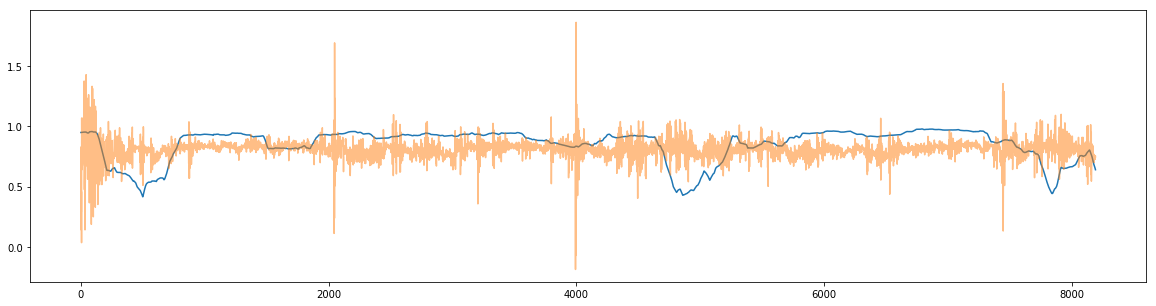

In [15]:
xt,yt = generate_training_batch()
yt_preds = model.predict(xt)

plt.figure(figsize=(20,5))
plt.plot(yt[0,...,0])
plt.plot(yt_preds[0,...,0], alpha=0.5)
plt.show()

#plt.figure(figsize=(20,5))
#plt.plot(yt[0,...,1], alpha=0.5)
#plt.plot(yt_preds[0,...,1], alpha=0.5)
#plt.show()

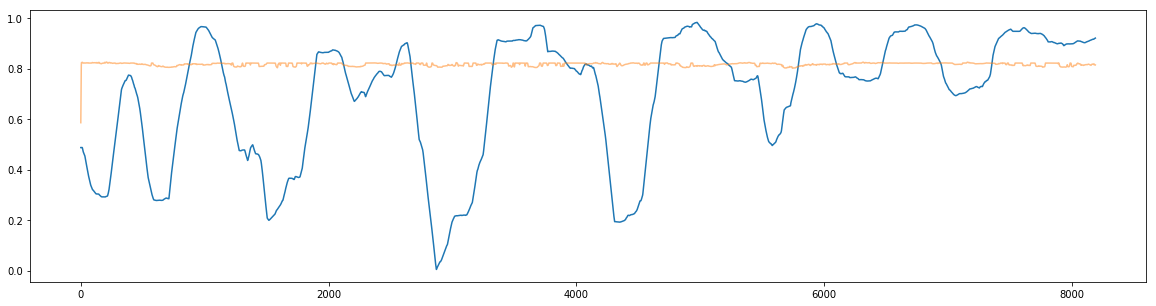

In [10]:
xv,yv = generate_training_batch()
yv_preds = model.predict(xv)

plt.figure(figsize=(20,5))
plt.plot(yv[0,...,0])
plt.plot(yv_preds[0,...,0], alpha=0.5)
plt.show()

#plt.figure(figsize=(20,5))
#plt.plot(yv[0,...,1].T, alpha=0.5)
#plt.plot(yv_preds[0,...,1].T, alpha=0.5)
#plt.show()

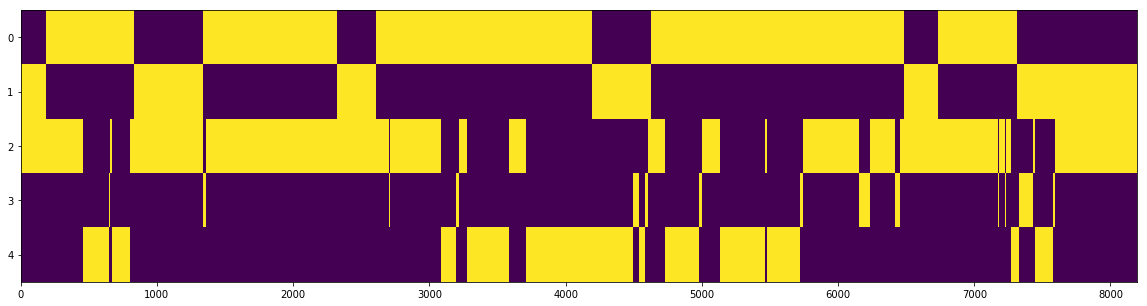

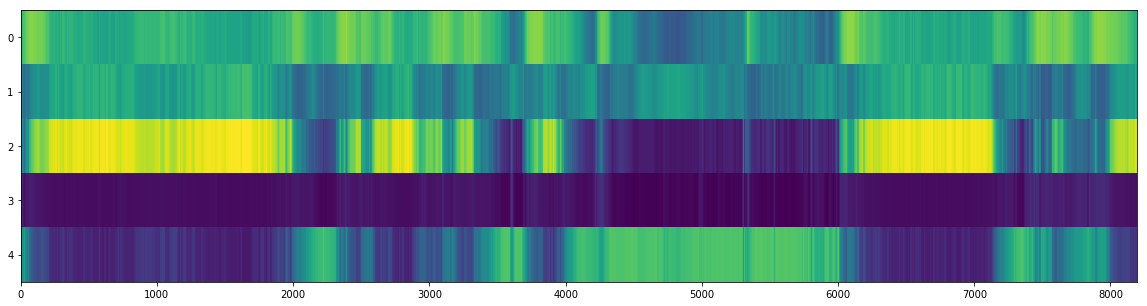

In [136]:
xt,yt = generate_training_batch()
yt_preds = model.predict(xt)

plt.figure(figsize=(20,5))
plt.imshow(yt[0].T, aspect='auto')
plt.show()
plt.figure(figsize=(20,5))
plt.imshow(yt_preds[0].T, aspect='auto')
plt.show()

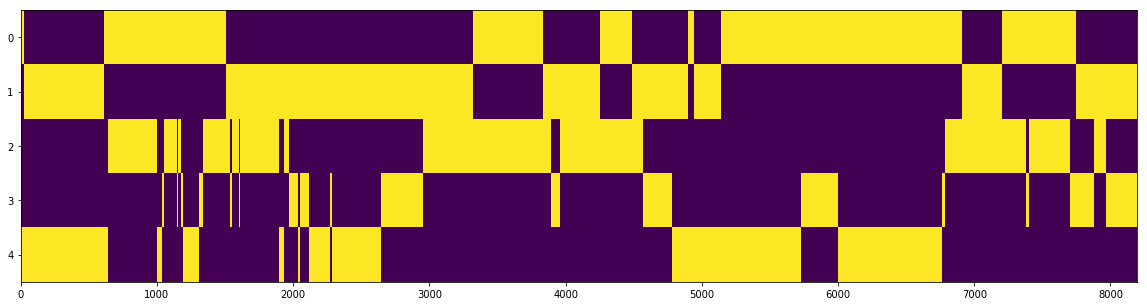

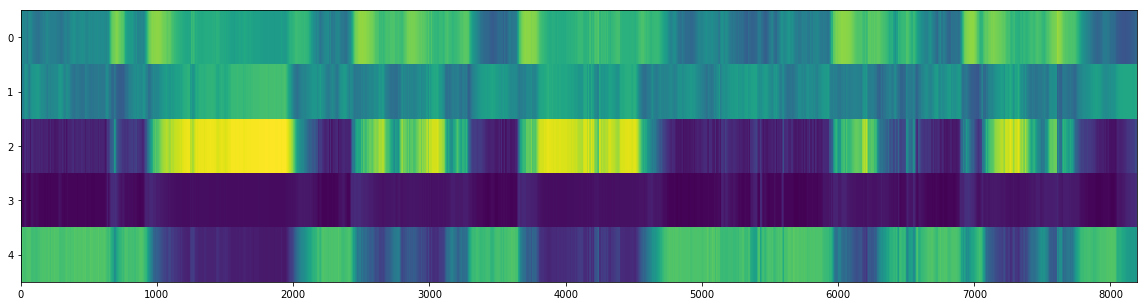

In [137]:
xv,yv = generate_validation_batch()
yv_preds = model.predict(xv)

plt.figure(figsize=(20,5))
plt.imshow(yv[0].T, aspect='auto')
plt.show()
plt.figure(figsize=(20,5))
plt.imshow(yv_preds[0].T, aspect='auto')
plt.show()